Some comments

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import copy
import numpy as np
repo_dir = '/datasets/hsc/repo/rerun/DM-13666/WIDE'
assert os.path.isdir(repo_dir)

import lsst.daf.persistence as daf_persistence
butler = daf_persistence.Butler(repo_dir)

In [3]:
coadd_skymap = butler.get('deepCoadd_skyMap')

In [4]:
#dir(coadd_skymap)

In [5]:
#help(coadd_skymap.findTractPatchList)

In [6]:
import h5py
spatial_lookup_filename = '/project/danielsf/valid_hsc_visit_extent.h5'
assert os.path.isfile(spatial_lookup_filename)
spatial_lookup = h5py.File(spatial_lookup_filename, 'r')

In [7]:
visit_num = spatial_lookup['visit'][11625]

In [8]:
all_visit = np.where(spatial_lookup['visit'][()]==visit_num)

In [9]:
ra_min = spatial_lookup['ra_min'][()][all_visit].min()
ra_max = spatial_lookup['ra_max'][()][all_visit].max()
dec_min = spatial_lookup['dec_min'][()][all_visit].min()
dec_max = spatial_lookup['dec_max'][()][all_visit].max()

In [10]:
all_coverage = np.where(np.logical_and(spatial_lookup['ra_center'][()]>ra_min,
                        np.logical_and(spatial_lookup['ra_center'][()]<ra_max,
                        np.logical_and(spatial_lookup['dec_center'][()]>dec_min,
                                       spatial_lookup['dec_center'][()]<dec_max))))

In [11]:
np.unique(spatial_lookup['filter'][()][all_coverage])

array([b'HSC-G', b'HSC-I', b'HSC-R', b'HSC-Y', b'HSC-Z'], dtype='|S5')

In [12]:
import lsst.geom as lsst_geom

In [13]:
pt_list = []
for ra in np.arange(ra_min, ra_max, 0.005):
    for dec in np.arange(dec_min, dec_max, 0.005):
        pt_list.append(lsst_geom.SpherePoint(ra, dec, lsst_geom.radians))

In [14]:
tract_patch_list = coadd_skymap.findTractPatchList(pt_list)

In [15]:
type(tract_patch_list[0][1][0])

lsst.skymap.patchInfo.PatchInfo

In [16]:
blank_data_id = {'tract':tract_patch_list[0][0].getId(),
           'patch': str(tract_patch_list[0][1][0].getIndex()).replace('(','').replace(')','').replace(' ','')}

In [17]:
butler.getKeys(datasetType='deepCoadd')

{'filter': str, 'tract': int, 'patch': str}

In [238]:
coadd_unq_id = []
coadd_g_mags = []
coadd_r_mags = []
coadd_i_mags = []

coadd_g_model = []
coadd_r_model = []
coadd_i_model = []

coadd_ra = []
coadd_dec = []

tract_id = tract_patch_list[0][0].getId()
for patch_obj in tract_patch_list[0][1][:50]:
    patch_id = str(patch_obj.getIndex()).replace('(','').replace(')','').replace(' ','')
    blank_data_id = {'tract': tract_id, 'patch':patch_id}

    data_id_g = copy.deepcopy(blank_data_id)
    data_id_g['filter'] = 'HSC-G'
    data_id_r = copy.deepcopy(blank_data_id)
    data_id_r['filter'] = 'HSC-R'
    data_id_i = copy.deepcopy(blank_data_id)
    data_id_i['filter'] = 'HSC-I'

    data_g = butler.get('deepCoadd_forced_src', dataId=data_id_g)#.asAstropy()
    data_r = butler.get('deepCoadd_forced_src', dataId=data_id_r)#.asAstropy()
    data_i = butler.get('deepCoadd_forced_src', dataId=data_id_i)#.asAstropy()

    extended_0 = np.logical_and(data_g['base_ClassificationExtendedness_value']==0,
                 np.logical_and(data_i['base_ClassificationExtendedness_value']==0,
                                data_r['base_ClassificationExtendedness_value']==0))

    well_measured = np.logical_and(data_g['base_PsfFlux_flag']==0,
                    np.logical_and(data_r['base_PsfFlux_flag']==0,
                                   data_i['base_PsfFlux_flag']==0))
    
    #print(len(stars[0]))
    
    np.testing.assert_array_equal(data_g['id'], data_r['id'])
    np.testing.assert_array_equal(data_g['id'], data_i['id'])
    np.testing.assert_array_equal(data_g['coord_ra'], data_r['coord_ra'])
    np.testing.assert_array_equal(data_g['coord_ra'], data_i['coord_ra'])
    np.testing.assert_array_equal(data_g['coord_dec'], data_r['coord_dec'])
    np.testing.assert_array_equal(data_g['coord_dec'], data_r['coord_dec'])

    calib_g = butler.get('deepCoadd_calexp_photoCalib', dataId=data_id_g)
    calib_r = butler.get('deepCoadd_calexp_photoCalib', dataId=data_id_r)
    calib_i = butler.get('deepCoadd_calexp_photoCalib', dataId=data_id_i)
    

    g_mag = calib_g.instFluxToMagnitude(data_g, 'base_PsfFlux')
    g_model = calib_g.instFluxToMagnitude(data_g, 'modelfit_CModel')
    r_mag = calib_r.instFluxToMagnitude(data_r, 'base_PsfFlux')
    r_model = calib_r.instFluxToMagnitude(data_r, 'modelfit_CModel')
    i_mag = calib_i.instFluxToMagnitude(data_i, 'base_PsfFlux')
    i_model = calib_i.instFluxToMagnitude(data_i, 'modelfit_CModel')

    #bright_enough = np.logical_and(g_mag[:,0]<25.0,
    #                np.logical_and(r_mag[:,0]<25.0, i_mag[:,0]<25.0))
    
    bright_enough = np.logical_and(np.abs(g_mag[:,0]-g_model[:,0])<0.03,
                    np.logical_and(np.abs(r_mag[:,0]-r_model[:,0])<0.03,
                                   np.abs(i_mag[:,0]-i_model[:,0])<0.03))
    
    is_finite = np.logical_and(np.isfinite(g_mag[:,0]),
                np.logical_and(np.isfinite(r_mag[:,0]), np.isfinite(i_mag[:,0])))
    
    stars  = extended_0 & well_measured & bright_enough & is_finite
    
    coadd_g_mags.append(g_mag[:,0][stars])
    coadd_g_model.append(g_model[:,0][stars])
    coadd_r_mags.append(r_mag[:,0][stars])
    coadd_r_model.append(r_model[:,0][stars])
    coadd_i_mags.append(i_mag[:,0][stars])
    coadd_i_model.append(i_model[:,0][stars])
    
    coadd_ra.append(data_g['coord_ra'][stars])
    coadd_dec.append(data_g['coord_dec'][stars])
    coadd_unq_id.append(data_g['id'][stars])

    
    #coadd_g_mags.append(calib_g.instFluxToMagnitude(data_g['base_PsfFlux_instFlux']))
    #coadd_r_mags.append(calib_r.instFluxToMagnitude(data_r['base_PsfFlux_instFlux']))
    #coadd_i_mags.append(calib_i.instFluxToMagnitude(data_i['base_PsfFlux_instFlux']))

    
coadd_unq_id = np.concatenate(coadd_unq_id)
coadd_ra = np.concatenate(coadd_ra)
coadd_dec = np.concatenate(coadd_dec)
coadd_g_mags = np.concatenate(coadd_g_mags)
coadd_r_mags = np.concatenate(coadd_r_mags)
coadd_i_mags = np.concatenate(coadd_i_mags)
coadd_g_model = np.concatenate(coadd_g_model)
coadd_r_model = np.concatenate(coadd_r_model)
coadd_i_model = np.concatenate(coadd_i_model)

/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in less
/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel/__main__.py:62: RuntimeWarning: invalid value encountered in less
/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: invalid value encountered in less


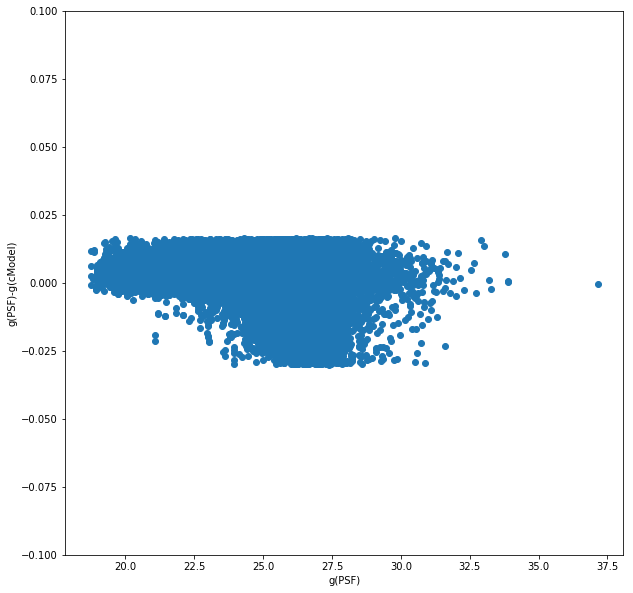

18.73717223079709


In [240]:
plt.figure(figsize=(10,10))
plt.scatter(coadd_g_mags, coadd_g_mags-coadd_g_model)
plt.xlabel('g(PSF)')
plt.ylabel('g(PSF)-g(cModel)')
plt.ylim(-0.1,0.1)
plt.show()
print(coadd_g_mags.min())

15234


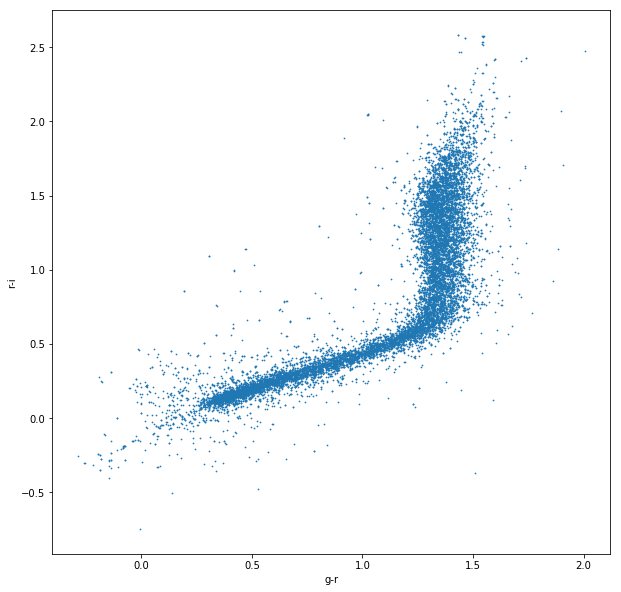

In [241]:
plt.figure(figsize=(10,10))
#plt.scatter(coadd_g_mags-coadd_r_mags, coadd_r_mags-coadd_i_mags,s=0.5)
valid_meas = np.logical_and(np.isfinite(coadd_g_mags),
                 np.logical_and(np.isfinite(coadd_r_mags), np.isfinite(coadd_i_mags)))

bright_enough = np.logical_and(coadd_g_mags<25.0,
                np.logical_and(coadd_r_mags<25.0, coadd_i_mags<25.0))

valid = np.where(np.logical_and(valid_meas, bright_enough))
print(len(valid[0]))
plt.scatter(coadd_g_mags[valid]-coadd_r_mags[valid],
            coadd_r_mags[valid]-coadd_i_mags[valid],s=0.5)

#plt.hist2d(coadd_g_mags[valid]-coadd_r_mags[valid],
#           coadd_r_mags[valid]-coadd_i_mags[valid], bins=(200,200), cmap=plt.cm.jet)
plt.xlabel('g-r')
plt.ylabel('r-i')
#plt.ylim(20,35)
#plt.xlim(-5,5)
plt.show()

In [44]:
import scipy.spatial as scipy_spatial
coadd_ra_normalized = coadd_ra/np.cos(coadd_dec)
coadd_spatial_data = np.array([coadd_ra_normalized, coadd_dec]).transpose()
coadd_spatial_tree = scipy_spatial.cKDTree(coadd_spatial_data, leafsize=16)

In [136]:
dex = all_coverage[0][0]
data_id_single = {'visit': int(spatial_lookup['visit'][()][dex]),
                  'ccd': int(spatial_lookup['ccd'][()][dex]),
                  'filter': spatial_lookup['filter'][()][dex].decode()}
data_single = butler.get('src', dataId=data_id_single)

In [140]:
normalized_ra = data_single['coord_ra']/np.cos(data_single['coord_dec'])
spatial_data = np.array([normalized_ra, data_single['coord_dec']]).transpose()

In [142]:
fit_dist, fit_dex = coadd_spatial_tree.query(spatial_data)

In [163]:
within_arcsec = np.where(np.logical_and(fit_dist<np.radians(1.0/3600.0),
                                        data_single['base_ClassificationExtendedness_value']==0))

In [164]:
id_within_arcsec = data_single['id'][within_arcsec]

In [165]:
print(coadd_unq_id.min(),coadd_unq_id.max())
print(id_within_arcsec.min(),id_within_arcsec.max())

41565959051280431 41566096490268933
5404950054044057 5404950054044576


In [166]:
data_single['base_ClassificationExtendedness_value'][within_arcsec]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [167]:
fit_dex_within = fit_dex[within_arcsec]
print(len(fit_dex_within))
print(len(np.unique(fit_dex_within)))

47
42


In [117]:
data_g = butler.get('deepCoadd_forced_src', dataId=data_id_g).asAstropy()
data_r = butler.get('deepCoadd_forced_src', dataId=data_id_r).asAstropy()
data_i = butler.get('deepCoadd_forced_src', dataId=data_id_i).asAstropy()

In [106]:
for name in data.colnames:
    if 'endedness' in name:
        print(name)

base_ClassificationExtendedness_value
base_ClassificationExtendedness_flag


In [87]:
data_id = {}
data_id['visit']=6292
data_id['ccd']=38
data_id['filter']='HSC-G'
data_id_single['ccd'] = 38

print('data_id: ',data_id)
print('data_id_single: ',data_id_single)

print('ccd',data_id['ccd']==data_id_single['ccd'])
print('visit',data_id['visit']==data_id_single['visit'])
print('filter',data_id['filter']==data_id_single['filter'])
print('data_id==data_id_single: ',data_id==data_id_single)

print('data_id exists: ',butler.datasetExists('src', dataId=data_id))
print('data_id_single exists: ',butler.datasetExists('src', dataId=data_id_single))

print(type(data_id['filter']))
print(type(data_id_single['filter']))

data_id:  {'visit': 6292, 'ccd': 38, 'filter': 'HSC-G'}
data_id_single:  {'visit': 6292, 'ccd': 38, 'filter': 'HSC-G'}
ccd True
visit True
filter True
data_id==data_id_single:  True
data_id exists:  True
data_id_single exists:  False
<class 'str'>
<class 'str'>


In [130]:
data_id = {}
data_id['ccd'] = 38
data_id['visit'] = 6292
data_id['filter'] = 'HSC-G'
print(butler.datasetExists('src', dataId=data_id))
print()

data_id_b = {}
data_id_b['ccd'] = 38
data_id_b['visit'] = 6292
data_id_b['filter'] = np.bytes_('HSC-G').decode()
print(butler.datasetExists('src', dataId=data_id_b))
print()
filter_id = spatial_lookup['filter'][()][dex]
print(filter_id,type(filter_id))
data_id_b['filter'] = filter_id.decode()
print(data_id_b)
print(butler.datasetExists('src', dataId=data_id_b))

print(data_id_b==data_id_single)
print(butler.datasetExists('src', dataId=data_id_single))
data_id_single['filter'] = 'HSC-G'
data_id_single['visit'] = 6292
#data_id_single.pop('visist')
print('does it exist ',butler.datasetExists('src', dataId=data_id_single))
type(data_id_single['visit'])

True

True

b'HSC-G' <class 'numpy.bytes_'>
{'ccd': 38, 'visit': 6292, 'filter': 'HSC-G'}
True
True
True
does it exist  True


int

In [128]:
data_id_single

{'visit': 6292, 'ccd': 38, 'filter': 'HSC-G'}

In [110]:
np.bytes_('abcd').decode()

'abcd'

In [193]:
data_g.getSchema()

Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
    (Field['I'](name="deblend_nChild", doc="Number of children this object has (defaults to 0)"), Key<I>(offset=32, nElements=1)),
    (Field['D'](name="base_SdssCentroid_x", doc="centroid from Sdss Centroid algorithm", units="pixel"), Key<D>(offset=40, nElements=1)),
    (Field['D'](name="base_SdssCentroid_y", doc="centroid from Sdss Centroid algorithm", units="pixel"), Key<D>(offset=48, nElements=1)),
    (Field['F'](name="base_SdssCentroid_xSigma", doc="1-sigma uncertainty on x position", units="pixel"), Key<F>(offset=56, nElements=1)),
    (Field['F'](name="base_SdssCentroid_ySigma", doc="1-sigma uncert

In [196]:
data_g['modelfit_CModel_flux']

array([        nan,         nan,         nan, ...,  0.67744539,
       12.72597617, 12.0582546 ])

In [139]:
stars = np.where(data_g['base_ClassificationExtendedness_value']==0)

In [120]:
stars_r = np.where(data_r['base_ClassificationExtendedness_value']==0)
data_g['id'][:10]

41565959051280385
41565959051280386
41565959051280387
41565959051280389
41565959051280390
41565959051280391
41565959051280392
41565959051280393
41565959051280394
41565959051280395


In [136]:
np.testing.assert_array_equal(data_g['id'], data_r['id'])
np.testing.assert_array_equal(data_g['id'], data_i['id'])

In [124]:
stars_r[0]

array([   19,    37,    47, ..., 24382, 24386, 24387])

In [125]:
stars[0]

array([   37,    49,    52, ..., 24382, 24385, 24389])

In [126]:
len(stars_r[0])

5309

In [127]:
len(stars[0])

4563

In [129]:
stars_r[0][3]

49

In [134]:
np.any(data_g['base_ClassificationExtendedness_flag'][stars])

False

In [152]:
stars = np.where(np.logical_and(data_g['base_ClassificationExtendedness_value']==0,
                 np.logical_and(data_i['base_ClassificationExtendedness_value']==0,
                                data_r['base_ClassificationExtendedness_value']==0)))

In [153]:
len(stars[0])

2346

In [156]:
calib = butler.get('deepCoadd_calexp_photoCalib', dataId=data_id_r)

In [158]:
dir(calib)

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '_getFlux',
 '_getFluxMag0',
 '_getMagnitude',
 '_getThrowOnNegativeFlux',
 '_setThrowOnNegativeFlux',
 'calibrateCatalog',
 'calibrateImage',
 'computeScaledCalibration',
 'computeScalingTo',
 'getCalibrationErr',
 'getCalibrationMean',
 'getFlux',
 'getFluxMag0',
 'getInstFluxAtZeroMagnitude',
 'getMagnitude',
 'getThrowOnNegativeFlux',
 'instFluxToMagnitude',
 'instFluxToNanojansky',
 'isPersistable',
 'magnitudeToInstFlux',
 'readFits',
 'setFluxMag0',
 'setThrowOnNegativeFlux',
 'writeFits']

In [161]:
help(calib.instFluxToMagnitude)

Help on method instFluxToMagnitude in module lsst.afw.image.photoCalib:

instFluxToMagnitude(...) method of lsst.afw.image.photoCalib.PhotoCalib instance
    instFluxToMagnitude(*args, **kwargs)
    Overloaded function.
    
    1. instFluxToMagnitude(self: lsst.afw.image.photoCalib.PhotoCalib, instFlux: float, point: lsst.geom.Point2D) -> float
    
    2. instFluxToMagnitude(self: lsst.afw.image.photoCalib.PhotoCalib, instFlux: float) -> float
    
    3. instFluxToMagnitude(self: lsst.afw.image.photoCalib.PhotoCalib, instFlux: float, instFluxErr: float, point: lsst.geom.Point2D) -> lsst.afw.image.photoCalib.Measurement
    
    4. instFluxToMagnitude(self: lsst.afw.image.photoCalib.PhotoCalib, instFlux: float, instFluxErr: float) -> lsst.afw.image.photoCalib.Measurement
    
    5. instFluxToMagnitude(self: lsst.afw.image.photoCalib.PhotoCalib, sourceRecord: lsst.afw.table.SourceRecord, instFluxField: str) -> lsst.afw.image.photoCalib.Measurement
    
    6. instFluxToMagnitude(self

In [23]:
help(calib_g.instFluxToMagnitude)

Help on method instFluxToMagnitude in module lsst.afw.image.photoCalib:

instFluxToMagnitude(...) method of lsst.afw.image.photoCalib.PhotoCalib instance
    instFluxToMagnitude(*args, **kwargs)
    Overloaded function.
    
    1. instFluxToMagnitude(self: lsst.afw.image.photoCalib.PhotoCalib, instFlux: float, point: lsst.geom.Point2D) -> float
    
    2. instFluxToMagnitude(self: lsst.afw.image.photoCalib.PhotoCalib, instFlux: float) -> float
    
    3. instFluxToMagnitude(self: lsst.afw.image.photoCalib.PhotoCalib, instFlux: float, instFluxErr: float, point: lsst.geom.Point2D) -> lsst.afw.image.photoCalib.Measurement
    
    4. instFluxToMagnitude(self: lsst.afw.image.photoCalib.PhotoCalib, instFlux: float, instFluxErr: float) -> lsst.afw.image.photoCalib.Measurement
    
    5. instFluxToMagnitude(self: lsst.afw.image.photoCalib.PhotoCalib, sourceRecord: lsst.afw.table.SourceRecord, instFluxField: str) -> lsst.afw.image.photoCalib.Measurement
    
    6. instFluxToMagnitude(self